## **SARIMAX**  
### **S**easonal **A**uto**R**egressive **I**ntegrated **M**oving **A**verage e**X**ogenous Model

This model is compromised out of three parts.
- AR = p
- I = d
- MA = q

The seasonal part is made up out of the same parts but are named capital P, D, Q and one additionsal parameter, s or m.
s is the value for the frequency of the seasonality.

I is the correction for the trend value, normally a ARMA model would be much simpler to use but that would mean our data needs to be stationary. I in this model helps us correct the data for the trend which we will se later on that we have in our data. 

X, exogenous is a variable imposed outside of the model and affects the result i.e. our features in this case. 
This has proven very useful for this data since our y values are affected by non seasonal or trend associated factors, such as big holidays. They would normally be very hard to predict but thanks to the exogenous variables we can try and make some correction for these events, as opposed to a normal SARIMA. Example will be given below trying to predict the days prior to and post Easter.

Basically, Sarimax consists of the same model reapeaded twice:  **(p, d, q)(P, D, Q, s)**
The first part looks at the local trend and the latter at the seasonal trend.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from matplotlib import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

sns.set(style='darkgrid', palette='muted', font_scale=1, rc={'figure.figsize':(20,10)})

RANDOM_SEED = 32
np.random.seed(RANDOM_SEED)

In [44]:
def load_data(path, columns, start=None, stop=None):
    df = pd.read_pickle(path)
    return df.loc[start:stop, columns]

In [45]:
df = load_data('../../data/ica_summary.pkl', columns=['artiklar'])

### Create all features

Differs slightly from LSTM.

Holidays are on the actual day of the holiday and not before.

SARIMA, unlike the LSTM model, doesn't take the actual sales as feature variable. There is no time_shift preparation needed for this model. So we do not need to correct for holidays feature to be on the day prior to the holiday.

In [46]:
def icas_egna_features(df):
    features = {}

    def add_weekday(features):
        features['weekday'] = pd.Series(df.index.weekday, index=df.index)
    
    def add_day_of_month(features):
        features['day_of_month'] = pd.Series(df.index.day, index=df.index)
    
    def add_mini_holiday(features):
        holidays = ['2021-01-01', '2021-01-06', '2021-04-02', '2021-04-04', '2021-04-05', '2020-05-21', '2020-05-31', '2020-06-06', '2020-06-20', '2020-10-31', '2020-12-25', '2020-12-26']
        features['holiday'] = pd.Series(np.where(df.index.isin(holidays), 1, 0), index=df.index)
    
    def add_before_holiday(features):
        features['before_holiday'] = pd.Series(0, index=df.index)
        before_holidays = ['2020-12-31', '2021-04-02', '2020-06-19', '2020-12-24']
        for holiday in before_holidays:
            for j, i in enumerate([3, 2, 1], 1):
                features['before_holiday'][pd.to_datetime(holiday) - pd.DateOffset(j)] = i
    
    def add_payday(features, payday, pension=False):
        if pension:
            if 'pension' not in features:
                features['pension'] = pd.Series(0, index=df.index) 
                series = features['pension']
            else:
                series = features['pension']
                
        if not pension:
            features['payday'] = pd.Series(0, index=df.index)
            series = features['payday']
        
        for i, day in enumerate(features['day_of_month']):
            if day == payday:
                if features['weekday'].iloc[i] in [5, 6] or features['holiday'].iloc[i]:
                    paydays = i - 1 if features['weekday'].iloc[i-1] not in [5, 6] or features['holiday'].iloc[i -1] else i - 2
                    series.iloc[paydays] = 1 
                else:
                    series.iloc[i] = 1
    
    add_weekday(features)
    add_day_of_month(features)
    add_mini_holiday(features)
    add_before_holiday(features)
    add_payday(features, 25)
    add_payday(features, 18, pension=True)
    add_payday(features, 17, pension=True)

    return features

In [47]:
features = icas_egna_features(df)

### Feature engineering

Finding the correct seasonal settings for all of the feature combinations takes a lot of time. In this example we only test the most basic combinations of features.

They behave marginally different. We will look at 4 different models, scaled and unscaled data. With and without exogenous variables. 

In [48]:
def add_basic_combination_feature(df, features):
    df_list = [df]
    for i, feat in enumerate(features, 1):
        ts = df.copy()
        for j in range(i):
            ts[list(features.keys())[j]] = list(features.values())[j]
        df_list.append(ts)
    return df_list

In [49]:
df_list = add_basic_combination_feature(df, features)

In [67]:
df_list[-1]

,artiklar,weekday,day_of_month,holiday,before_holiday,payday,pension
2020-05-04,1016.0,0,4,0,0,0,0
2020-05-05,1317.0,1,5,0,0,0,0
2020-05-06,1027.0,2,6,0,0,0,0
2020-05-07,1572.0,3,7,0,0,0,0
2020-05-08,1509.0,4,8,0,0,0,0
...,...,...,...,...,...,...,...
2021-04-06,2066.0,1,6,0,0,0,0
2021-04-07,2182.0,2,7,0,0,0,0
2021-04-08,3944.0,3,8,0,0,0,0
2021-04-09,3709.0,4,9,0,0,0,0


In [50]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

def scale_data(df_list):
    scaled_df_list = []
    for df in df_list:
        min_max_scaler_x = MinMaxScaler(feature_range=(0, 1))
        min_max_scaler_y = MinMaxScaler(feature_range=(0, 1))
        
        scalers = [[min_max_scaler_x, min_max_scaler_y]]

        if len(df.columns) == 1:
            scaled_df_list.append({'X': df.iloc[:].to_numpy().reshape(-1, 1), 
                                   'y': df.iloc[:].to_numpy().reshape(-1, 1), 
                                   'scaler_x': None, 
                                   'scaler_y': None,
                                   'features': df.columns})
        else:
            scaled_df_list.append({'X': df.iloc[:, 1:].to_numpy(), 
                                   'y': df.iloc[:, 0].to_numpy().reshape(-1, 1), 
                                   'scaler_x': None, 
                                   'scaler_y': None,
                                   'features': df.columns})

        for scaler in scalers:
            if len(df.columns) == 1:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'y': scaler[1].fit_transform(df.iloc[:].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
            else:
                scaled_df_list.append({'X': scaler[0].fit_transform(df.iloc[:, 1:].to_numpy()), 
                                       'y': scaler[1].fit_transform(df.iloc[:, 0].to_numpy().reshape(-1, 1)), 
                                       'scaler_x': scaler[0], 
                                       'scaler_y': scaler[1],
                                       'features': df.columns})
    
    return scaled_df_list

### Only pass in two models, with and without exogenous variables

In [51]:
scaled_data = scale_data([df_list[0], df_list[-1]])

In [52]:
def split_train_test(scaled_data, test_size):
    
    return [{'X_train': df['X'][:len(df['X']) - test_size], 
             'y_train': df['y'][:len(df['X']) - test_size],
             'X_test': df['X'][len(df['X']) - test_size:],
             'y_test': df['y'][len(df['X']) - test_size:],
             'scaler_x': df['scaler_x'],
             'scaler_y': df['scaler_y'],
             'features': df['features']} 
             for df in scaled_data]

In [53]:
train_test = split_train_test(scaled_data, 7)

### Statsmodels Visualization

We can use a great tool for previewing our data and start to make predictions about what p,d,q and P,D,Q,s values would be optimal for this data.

- Basic visual plot of data artiklar, our y values.
- Trend / Seasonal trend. Here we can se that the trend is increasing over time.
- Residual values, what is left over. Preferably this is only white noise, which is, to the model unpredictable.
- ACF / PACT
    - To determine our AR value we would start looking at the PACT plot. We get a rough picture of the correlation between our y values. Partial Autocorrelation shows the direct and indirect correlation we see that 1, 2, 6, 7 are values that show signs of correlation above the greyed out area which is statistically 0 correlation.
    - ACF shows  only the direct correlation and helps us determin our MA value. Looking at the plot below suggest a value of 1, 6 or 7.
- Seasonality is the frequency of the trend. In our case we see that the pattern repeats every 7th, 14th, 21th value. Both from the ACF and the Seasonal Trend chart. This suggest a s value of 7. Thus removing 7 from our initial AR and MA lower p & q. (Else we would  look at the same point for (p, q) and (P, Q)) Leaving values 1,2,6 for p and 1 for q. P would be preferably 1, or 2. Q would also be 1 or 2. Depending on how many weeks back we would like to take into consideration. 

Takeaway from this visualization gives us an indication that good starting values could be:  
**p** = 1, 2 or 6  
**d** = 1 (default)  
**q** = 1 or 6  
**P** = 1 or 2  
**D** = 1 (default)  
**Q** = 1 or 2  
**s** = 7  

We have additional tools to help us search through the optimal settings but this gives us a good idea of what to expect. 

In [54]:
def visualize_y(df):
    seas_d = sm.tsa.seasonal_decompose(df_list[0].artiklar, model='ass', period=7)

    fig = seas_d.plot()
    fig.set_figheight(10)
    plt.show()
    
    fig, ax = plt.subplots(2,1, figsize=(20,5))
    fig = sm.tsa.graphics.plot_acf(train_test[0]['y_train'], lags=25, ax=ax[0])
    fig = sm.tsa.graphics.plot_pacf(train_test[0]['y_train'], lags=25, ax=ax[1])
    plt.show()

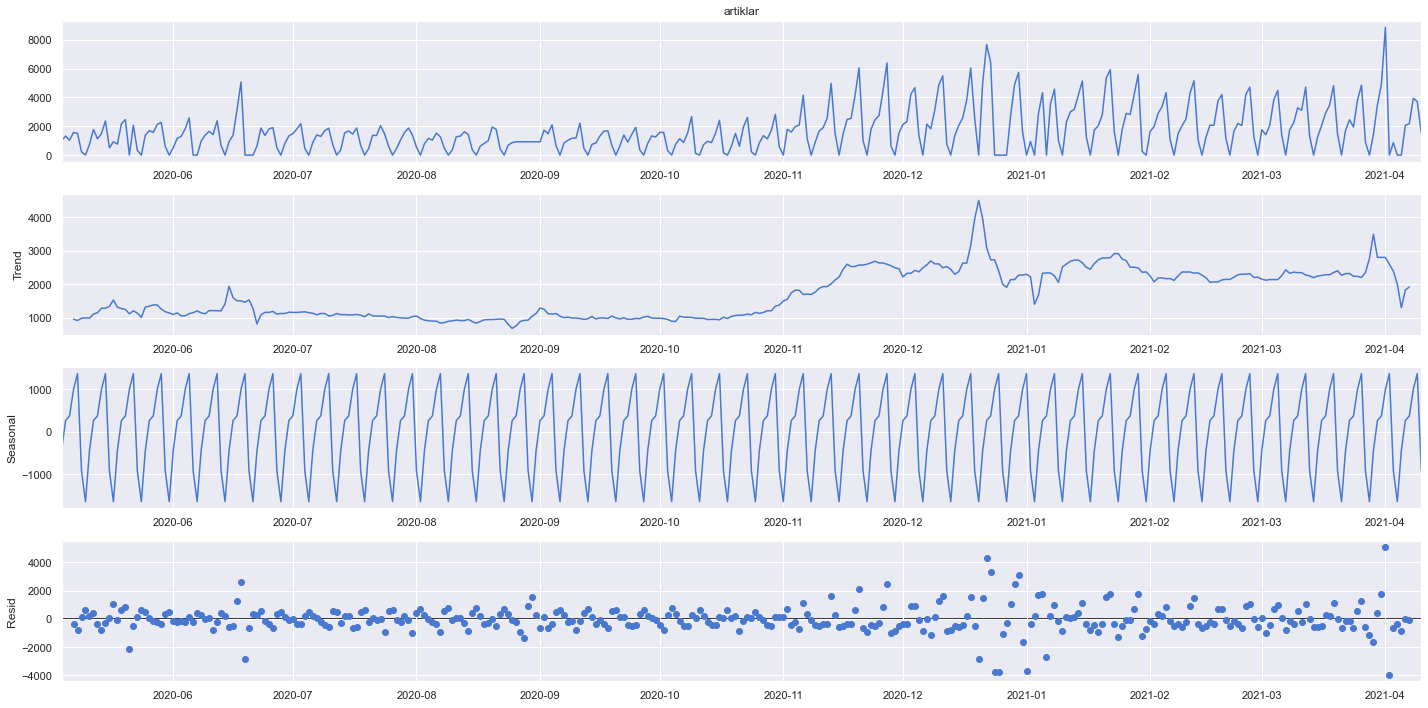

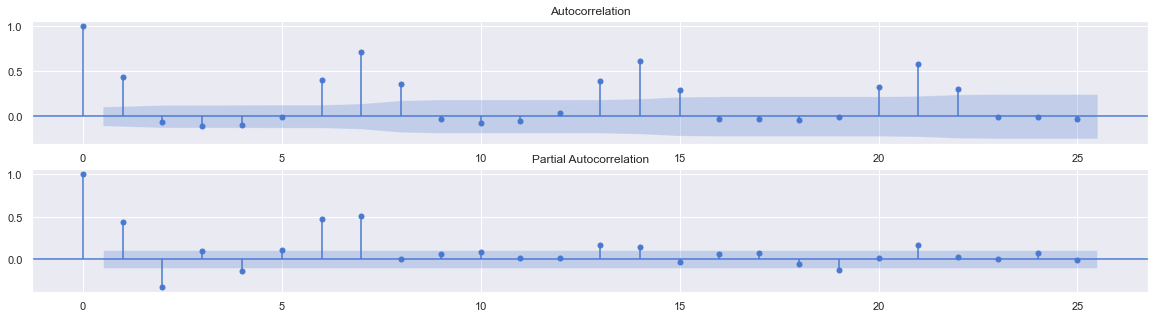

In [55]:
visualize_y(train_test)

### AUTO_ARIMA

We ended up with some variations of (pdq, PDQ) after looking at the initial data decomposition. We could use a tool to test these different setting and search for the lowest AIC, Akaike information criterion, wich is an estimator for prediction error. 

Optimal setting are then saved together with the original dict containing information about the model features.

In [56]:
def find_optimal_params(df_list):
    trained_df = []
    for i, df in enumerate(df_list, 1):
        print(f'> Training {i}/{len(df_list)} <'.center(50, '-'))
        step_wise = auto_arima(df['y_train'], 
                           exogenous=df['X_train'] if (df['X_test']!=df['y_test']).all() else None,
                           start_P=1, max_P=2,
                           D=1, max_D=2,
                           start_Q=1, max_Q=2,
                           start_p=1, start_q=1,
                           max_p=6, max_q=6,
                           d=1, max_d=2,
                           m=7,
                           seasonal=True,
                           trace=True,
                           error_action='ignore', 
                           suppress_warnings=True, 
                           stepwise=True)
        trained_df.append({**df, **{'order': step_wise.order,
                                    'seasonal_order': step_wise.seasonal_order}})
    
    return trained_df

In [16]:
optimized_df = find_optimal_params(train_test)

-----------------> Training 1/4 <-----------------
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=5424.036, Time=1.75 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5653.628, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5603.435, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=5425.796, Time=3.39 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=5425.674, Time=3.36 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=inf, Time=1.78 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=2.07 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=5436.427, Time=1.11 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=5545.421, Time=0.70 sec
 ARIMA(2,1,1)(1,1

### Save so we don't have to re-do the auto-arima every time

In [ ]:
def save_results(df_list, name):
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(df_list, f)

In [ ]:
save_results(optimized_df, 'fitted_dfs_presentation')

In [4]:
def open_results(name):
    with open(f'{name}.pkl', 'rb') as f:
        return pickle.load(f)

In [5]:
optimized_df = open_results('fitted_dfs_presentation')

### Testing / comparing models

- Load in a prepared dataframe with all known y values we have so far and exogenous variables for as long as we would like to make predictions for. We will use this to make predictions against, both for values that we know but also for dates that we don't have the answer for. But now we have the exogenous variables that we need to make those forecasts.

- We'll run this through a function that takes a start date as argument as well as how many days we wish to predict. The prepared dataframe is then used to take out the train/test based on the input. This enable us to customize our predictions based on timeframe and start_date.

- Then we'll plot all of the predictions and if we are within the scope of y values we know, compare scores.

In [6]:
def open_prep_df(name):
    with open(f'../original/{name}.pkl', 'rb') as f:
        return pickle.load(f)

In [7]:
prepared_df = open_prep_df('sarimax_pred')

In [8]:
prepared_df

,artiklar,weekday,day_of_month,holiday,before_holiday,payday,pension
2020-05-04,1016.0,0,4,0,0,0,0
2020-05-05,1317.0,1,5,0,0,0,0
2020-05-06,1027.0,2,6,0,0,0,0
2020-05-07,1572.0,3,7,0,0,0,0
2020-05-08,1509.0,4,8,0,0,0,0
...,...,...,...,...,...,...,...
2021-09-03,0.0,4,3,0,0,0,0
2021-09-04,0.0,5,4,0,0,0,0
2021-09-05,0.0,6,5,0,0,0,0
2021-09-06,0.0,0,6,0,0,0,0


In [9]:
def get_scores(df, y_test, forecast):
        if df['scaler_y']:
            y_true = df['scaler_y'].inverse_transform(y_test)
            y_pred = df['scaler_y'].inverse_transform(forecast.predicted_mean.reshape(-1, 1))
            
            predictions = pd.DataFrame(zip(y_pred.flatten(),
                                      df['scaler_y'].inverse_transform(np.fromiter(map(lambda x: x[0], forecast.conf_int()), dtype=np.float).reshape(-1, 1)).flatten(),
                                      df['scaler_y'].inverse_transform(np.fromiter(map(lambda x: x[1], forecast.conf_int()), dtype=np.float).reshape(-1, 1)).flatten(),
                                      df['scaler_y'].inverse_transform(y_test)),
                                      columns=['forecast_mean', 'forecast_low', 'forecast_high', 'true'])
            return {'predictions': predictions,
                    'score': {'RMSE': np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)),
                                  'MAE': mean_absolute_error(y_true=y_true, y_pred=y_pred),
                                  'r2': r2_score(y_true=y_true, y_pred=y_pred)}}
        else:
            predictions = pd.DataFrame(zip(forecast.predicted_mean,
                                           list(map(lambda x: x[0], forecast.conf_int())),
                                           list(map(lambda x: x[1], forecast.conf_int())),
                                           y_test),
                                       columns=['forecast_mean', 'forecast_low', 'forecast_high', 'true'])
            
            return {'predictions': predictions,
                    'score': {'RMSE': np.sqrt(mean_squared_error(y_true=y_test, y_pred=forecast.predicted_mean)),
                                  'MAE': mean_absolute_error(y_true=y_test, y_pred=forecast.predicted_mean),
                                  'r2': r2_score(y_true=y_test, y_pred=forecast.predicted_mean)}}

In [10]:
def get_train_test(original_df, start_pred, predict_days, df):
    y_train = original_df.loc[:start_pred - pd.to_timedelta(1, unit='d'), 'artiklar'].to_numpy().reshape(-1, 1)
    x_train = original_df.loc[:start_pred - pd.to_timedelta(1, unit='d'), df['features']].drop(columns=['artiklar']).to_numpy()

    y_test = original_df.loc[start_pred: start_pred + pd.to_timedelta(predict_days - 1, unit='d'), 'artiklar'].to_numpy().reshape(-1, 1)
    x_test = original_df.loc[start_pred: start_pred + pd.to_timedelta(predict_days - 1, unit='d'), df['features']].drop(columns=['artiklar']).to_numpy()

    if df['scaler_y']:
        y_train, y_test = df['scaler_y'].transform(y_train), df['scaler_y'].transform(y_test)

        if x_train.size > 0:
            x_train, x_test = df['scaler_x'].transform(x_train), df['scaler_x'].transform(x_test)
    
    return y_train, x_train, y_test, x_test

In [11]:
def get_model(y_train, x_train, pdq, seasonal_pdq):
    return SARIMAX(y_train,
             exog=x_train if x_train.size > 0 else None,
             order=pdq,
             seasonal_order=seasonal_pdq,
             enforce_invertibility=False,
             enforce_stationarity=False)

In [12]:
def run_model(df_list, original_df, start_pred='2021-03-22', predict_days=7):
    fitted_df = []
    start_pred = pd.to_datetime(start_pred)
    for i, df in enumerate(df_list, 1):
        y_train, x_train, y_test, x_test = get_train_test(original_df, start_pred, predict_days, df) 
        
        model = get_model(y_train, x_train, df['order'], df['seasonal_order'])
        
        print(f'> Fitting model {i}/{len(df_list)} <'.center(50, '-'))
        
        results = model.fit(maxiter=100)
        forecast = results.get_forecast(steps=predict_days, exog=x_test if x_test.size > 0 else None)
        scores = get_scores(df, y_test, forecast)
        fitted_df.append({**df, **scores})
               
    return fitted_df

In [31]:
predictions = run_model(optimized_df, prepared_df, start_pred='2021-02-28', predict_days=42)

--------------> Fitting model 1/4 <---------------
--------------> Fitting model 2/4 <---------------
--------------> Fitting model 3/4 <---------------
--------------> Fitting model 4/4 <---------------


In [32]:
def plot_all_predictions(df_list):
    
    rows = len(df_list) // 3 if len(df_list) % 3 == 0 else (len(df_list) // 3) + 1
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, rows * 5))
    fig.suptitle('Predictions', size=30)
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if df_list[i]['predictions']['true'].iloc[-1][0]:
            ax.set_title(f'R2: {df_list[i]["score"]["r2"]:0.4f} pdq: {df_list[i]["order"], df_list[i]["seasonal_order"]} Scaler: {df_list[i]["scaler_y"]} Features: {len(df_list[i]["features"]) - 1}', size=15)
        else:
            ax.set_title(f'pdq: {df_list[i]["order"], df_list[i]["seasonal_order"]} Scaler: {df_list[i]["scaler_y"]} Features: {len(df_list[i]["features"]) - 1}', size=15)

        ax.plot(df_list[i]['predictions']['true'], label='True', marker='.')
        ax.plot(df_list[i]['predictions']['forecast_mean'], label='Prediction', marker='.')
        ax.fill_between(df_list[i]['predictions'].index,
                        df_list[i]['predictions']['forecast_low'],
                        df_list[i]['predictions']['forecast_high'], color='k', alpha=0.25)
        ax.legend(loc="lower left", prop={'size': 12})
        ax.tick_params(labelsize=12)
        if i == len(df_list) - 1:
            break

### RESULTS


**1st Model**
- Seasonality: 1 week ARMA
- No scaler
- No Features

We can se that the pattern repeats itself over and over with minor change with an increasing confidence index. The 0 value on every Sunday is also getting slightly higher for every week. Confirming the 1 weekly seasonality and an increased uncertainty of the prediction over time. The sale spike ahead of Easter is not predicted at all. Neither are the zero values for Friday or Monday.

**2nd Model**
- Seasonality: 2 week ARMA
- MinMaxScaler
- No Features

Confidence index behaves similar to that of the 1st model. Although here we can see different patterns for every week, as a result of PDQ looking back 2 weeks. Behaves the same for the easter sales.
Both model does a good job at predicting the sales during normal circumstances but fails as predicting abnormal situations.

**3rd Model**
- Seasonality: 1  week ARMA
- No scaler
- All Features

Here we can see a change in the confidence index compared to the two prevoius models. The increase is not as apparent and Easter is well predicted for, even over corrected. It still doesn't make the correct adjustment for the following closed friday but shows a larger than normal drop in value. It however, again, overcorrects on the sunday showing a negative value but correctly predict the closed Monday the following day. 

**4th Model**
- Seasonality: 2  week ARMA
- MinMaxScaler
- All Features

Very similar to the 3rd model, showing minor differences to its advantage landing the best r2 score for this timeframe. 

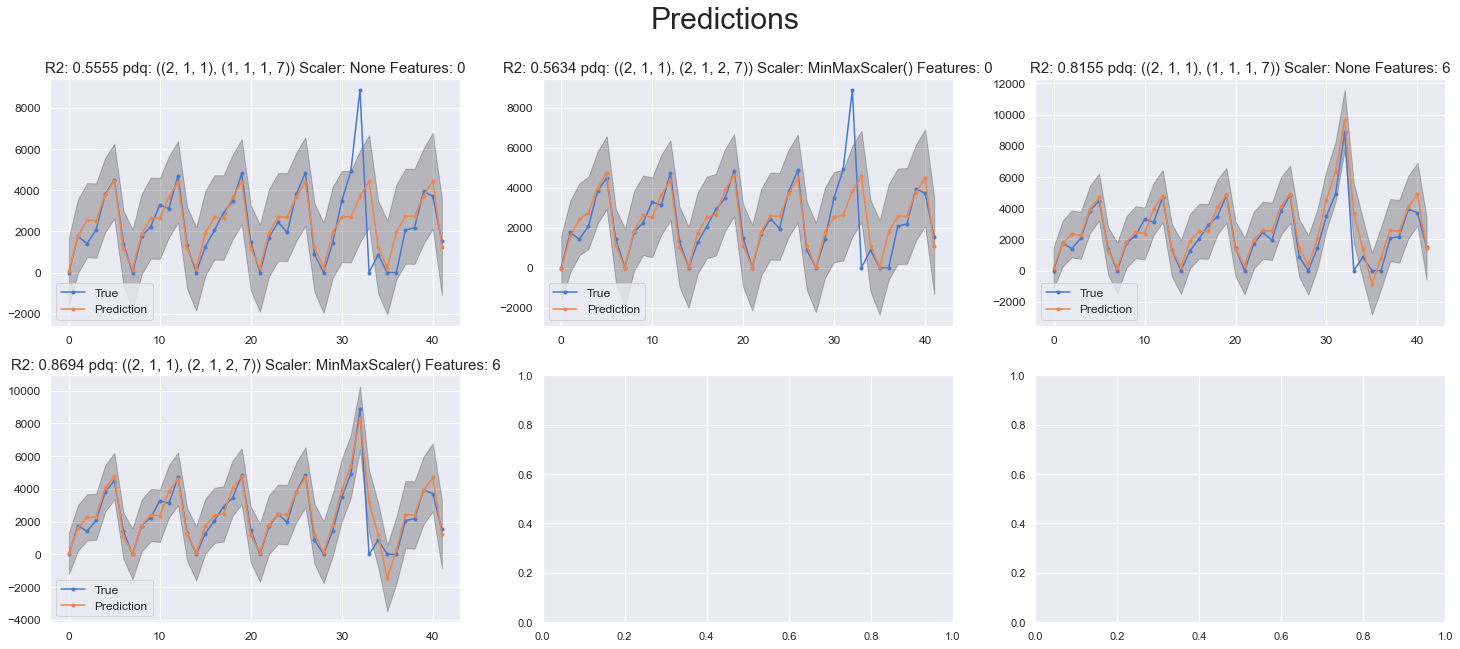

In [33]:
plot_all_predictions(predictions)